In [1]:
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs

In [2]:
# identify dataset TSV files
fnames = os.listdir("datasets/")
flist = []
for f in fnames:
    if "depth_frequency" in f:
        flist.append(f)

In [3]:
# populate dataframe from dataset TSV files
df = dict()
gdf = dict()
count = 0
for i in flist:
    df[count] = pd.read_table('datasets/' + i,
                              skiprows=np.arange(0,21)
                             )
    gdf[count] = gpd.GeoDataFrame(
        df[count],
        geometry=gpd.points_from_xy(
            df[count].Longitude, df[count].Latitude),
        crs="EPSG:4326"
    )
    count += 1

In [4]:
# get shoreline world file
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [5]:
# projection handling
crs = ccrs.SouthPolarStereo()
crs_proj4 = crs.proj4_init
for i in range(0, len(gdf)):
    gdf[i] = gdf[i].to_crs(crs_proj4)
world = world.to_crs(crs_proj4)

In [6]:
# convert to datetime objects
for i in range(0, len(gdf)):
    gdf[i]['Date/Time'] = pd.to_datetime(gdf[i]['Date/Time'], format='%Y-%m-%dT%H:%M')

In [7]:
# make time series
ts = gdf[0]['Date/Time']
for i in range(1, len(gdf)):
    ts = pd.concat([ts, gdf[i]['Date/Time']])
# remove duplicates
ts = ts.drop_duplicates()
# sort
ts = ts.sort_values(ignore_index=True)

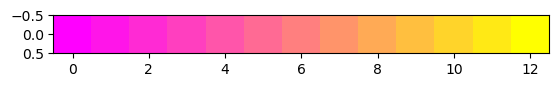

In [8]:
# define and plot colormap for points
from matplotlib import cm
cmap = cm.get_cmap('spring', len(gdf)*1.)
data = [list(np.arange(0, len(gdf)*1.))]
plt.imshow(data, cmap=cmap)

In [9]:
# ignore warnings in plot commands below
import warnings
warnings.filterwarnings('ignore')

In [10]:
from tqdm import tqdm

In [32]:
# do the plotting

fnum = 1

# time loop
for t in tqdm(range(0, len(ts), 5)):
    
    # set up antarctica shoreline and color
    ax = world[world.continent=='Antarctica'].plot(color='xkcd:ice blue',
                                               edgecolor='xkcd:light blue')
    
    # background ocean color
    ax.set_facecolor('xkcd:ocean blue')
    
    # loop through individual seals each in own gdf
    for i in range(0, len(gdf)):
        # # plot old times
        # for ti in range(0, t):
        #     gdf[i][gdf[i]['Date/Time']==ts[ti]].plot(
        #         ax=ax, color=cmap(i), markersize=25,
        #         edgecolor='k', linewidth=0.25, alpha=0.15, zorder=-1)
        # plot current time
        gdf[i][gdf[i]['Date/Time']==ts[t]].plot(
            ax=ax, color=cmap(i), markersize=100,
            edgecolor='k', linewidth=1.0, zorder=10)
        # all points for legend
        plt.scatter(0, 0, color=cmap(i), s=100, edgecolor='k', linewidth=1.0,
                    label=str(i))

    # axes limits
    ax.set_xlim([-2e6, 2.5e6])
    ax.set_ylim([0.5e6, 3e6])

    # axes labels
    ax.set_ylabel('Degrees Latitude')
    ax.set_xlabel('Degrees Longitude')
    ax.set_title('Seal Movements in the Weddell Sea in 1998\nData from Nachtsheim et al. 2016')
    ax.legend(loc='upper right', bbox_to_anchor=(1.17, 1.1),
              title='Seal #', title_fontsize='large')
    
    # datetime text
    ax.text(-0.45e6, 0.6e6, ts[t], fontsize=16)

    # save
    plt.savefig('frames/' + str(fnum).zfill(5) + '.png', dpi=200, bbox_inches='tight')
    
    # close figure
    plt.close()
    
    # increment frame number
    fnum += 1

100%|████████████████████████████████████████████████████████████████| 95/95 [01:34<00:00,  1.00it/s]
